In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import RFE, SelectFromModel
from scipy import stats

In [59]:
testSetSize = 0.25 #percentage of total set, same as paper
k = 2 # for K-fold cross-validation
linear = LinearRegression()
GB = GradientBoostingRegressor()
RF = RandomForestRegressor()
moddels = [('Linear',linear,RFE(linear)),
          ('Gradient Boosting', GB, SelectFromModel(GB,'mean')),
          ('Random Forests',RF,SelectFromModel(RF,'mean'))]

In [60]:
# Load and clean the data
data = pd.read_csv("../data/energydata_complete.csv").dropna(how='any')

#Cast for correct indxing
data['date'] = pd.to_datetime(data['date'])
data.set_index('date',inplace = True)

# Make sure everything has the correct type
data = data.astype(np.float64)
y = data['Appliances']
X = data.drop(['Appliances'],axis=1)

# Seperate data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSetSize,shuffle=True)


In [61]:
resultColumns = ['Algorithm','Feature set','MAE']
results = pd.DataFrame(columns=resultColumns)

scaler = MaxAbsScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

for name, model,selector in moddels:
    model.fit(X_train,y_train)
    acc = mean_absolute_error(y_test,model.predict(X_test))
    results.loc[len(results)] = pd.Series({'Algorithm':name,
                         'MAE':acc,
                         'Feature set' : 'full'})

    X_train_reduced = selector.fit_transform(X_train,y_train)
    X_test_reduced = selector.transform(X_test)

    model.fit(X_train_reduced,y_train)
    acc = mean_absolute_error(y_test,model.predict(X_test_reduced))
    results.loc[len(results)] = pd.Series({'Algorithm':name,
                         'MAE':acc,
                         'Feature set' : 'reduced'})
        
        

In [62]:
results.sort_values('MAE')
# print(results.sort_values('MAE').to_latex())

,Algorithm,Feature set,MAE
4,Random Forests,full,38.261046
5,Random Forests,reduced,38.340495
2,Gradient Boosting,full,47.994745
3,Gradient Boosting,reduced,48.965706
0,Linear,full,53.339191
1,Linear,reduced,53.696722


In [68]:
print('total number of features: ', X.shape[1])

RF = RandomForestRegressor()
RFSelector = SelectFromModel(RF,'mean')
RF.fit(X_train,y_train)
RFSelector.fit(X_train,y_train)

# which features perform well enough to keep?
print(X.loc[:,RFSelector.get_support()].columns)

total number of features:  27
Index(['lights', 'RH_1', 'RH_2', 'T3', 'RH_3', 'RH_5', 'T8', 'RH_8',
       'Press_mm_hg', 'RH_out'],
      dtype='object')


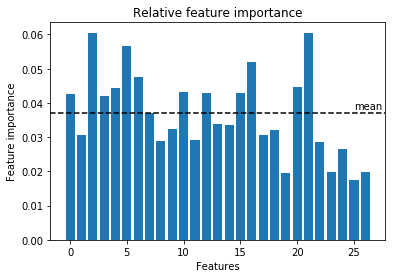

In [65]:
plt.bar(range(len(RF.feature_importances_)),RF.feature_importances_)
plt.axhline(y= RF.feature_importances_.mean(), hold=None, ls="dashed", color="black")
plt.text(x=25,y=RF.feature_importances_.mean()+0.001, s="mean", color="black")
plt.title("Relative feature importance")
plt.xlabel("Features")
plt.ylabel("Feature importance")
plt.show()
# 